In [1]:
import sys
sys.path.append('../../')

import numpy as np

In [2]:
from holisticai.benchmark.tasks import task_name, get_task

print(task_name)

['binary_classification', 'multiclass_classification', 'regression', 'clustering', 'recommender']


In [3]:
# load a task
task = get_task("binary_classification")

In [4]:
# benchmark for the task by type
data = task.benchmark(type='inprocessing')
data

Dataset,Average AFS,adult,bank_marketing,census_kdd,compas_recidivism,credit_card,diabetes,german_credit,law_school
Mitigator,,,,,,,,,
PrejudiceRemover,0.901988,0.876628,0.963592,0.953404,0.993200,0.894675,0.768062,0.857242,0.909100
GridSearchReduction,0.878838,0.835973,0.959813,0.955142,0.807752,0.902130,0.794675,0.912679,0.862537
MetaFairClassifier,0.816151,0.739085,0.951280,0.467710,0.827878,0.902962,0.805780,0.889563,0.944952


In [8]:
from holisticai.utils.transformers.bias import BMInprocessing as BMImp

from holisticai.bias.mitigation.inprocessing.meta_fair_classifier.algorithm import MetaFairClassifierAlgorithm
from holisticai.bias.mitigation.inprocessing.meta_fair_classifier.algorithm_utils import MFLogger
from holisticai.bias.mitigation.inprocessing.meta_fair_classifier.constraints import FalseDiscovery, StatisticalRate

from typing import Optional

class MyInprocessingMitigator(BMImp):
    """
    This is a class example of Inprocessing Mitigator based on MetaFairClassifier implemented in holisticai library
    """

    def __init__(
        self,
        tau: Optional[float] = 0.8,
        constraint: Optional[str] = "StatisticalRate",
        seed: Optional[int] = None,
        verbose: Optional[int] = 0,
    ):
        """
        Parameters
        ----------
            tau : float
                Fairness penalty parameter (0,1). Higher parameter increate the threshold
                for a valid estimator.

            constraint : str
                The type of fairness metric to be used, currently supported:
                - StatisticalRate: Statistical rate/disparate impact
                - FalseDiscovery: False discovery rate ratio

            seed : int
                Random seed.
        """
        # Constant parameters
        steps = 10
        eps = 0.01
        mu = 0.01

        logger = MFLogger(tau, eps=eps, steps=steps, verbose=verbose)

        if constraint == "StatisticalRate":
            constraint = StatisticalRate(mu=mu)

        elif constraint == "FalseDiscovery":
            constraint = FalseDiscovery(mu=mu)

        self.algorithm = MetaFairClassifierAlgorithm(
            constraint=constraint, tau=tau, eps=eps, steps=steps, logger=logger
        )
        self.seed = seed

    def transform_estimator(self, estimator=None):
        return self

    def fit(
        self,
        X: np.ndarray,
        y_true: np.ndarray,
        group_a: np.ndarray,
        group_b: np.ndarray,
    ):
        """
        Fit the model

        Description
        -----------
        Learn a fair classifier.

        Parameters
        ----------

        X : numpy array
            input matrix

        y_true : numpy array
            target vector

        group_a : numpy array
            binary mask vector

        group_b : numpy array
            binary mask vector

        Returns
        -------
        the same object
        """
        params = self._load_data(y_true=y_true, group_a=group_a, group_b=group_b)
        y_true = params["y_true"]
        group_a = params["group_a"]
        group_b = params["group_b"]
        sensitive_features = np.stack([group_a, group_b], axis=1)
        self.classes_ = params["classes_"]

        self.algorithm.fit(
            X=X, y=y_true, sensitive_features=sensitive_features, random_state=self.seed
        )
        return self

    def predict(self, X: np.ndarray):
        """
        Prediction

        Description
        ----------
        Predict output for the given samples.

        Parameters
        ----------
        X : pandas.DataFrame or numpy array
            Test samples.

        Returns
        -------

        numpy.ndarray: Predicted output per sample.
        """
        return self.algorithm.predict(X)

    def predict_proba(self, X: np.ndarray):
        """
        Probability Prediction

        Description
        ----------
        Probability estimate for the given samples.

        Parameters
        ----------
        X : pandas.DataFrame or numpy array
            Test samples.

        Returns
        -------
        numpy.ndarray
            probability output per sample.
        """
        return self.algorithm.predict_proba(X)

In [9]:
my_mitigator = MyInprocessingMitigator()

task.run_benchmark(mitigator = my_mitigator, type = 'inprocessing')

Binary Classification Benchmark initialized for AdversarialDebiasing


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 0/4 [00:00<?, ?it/s]

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 0/4 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
data = task.evaluate_table()
data

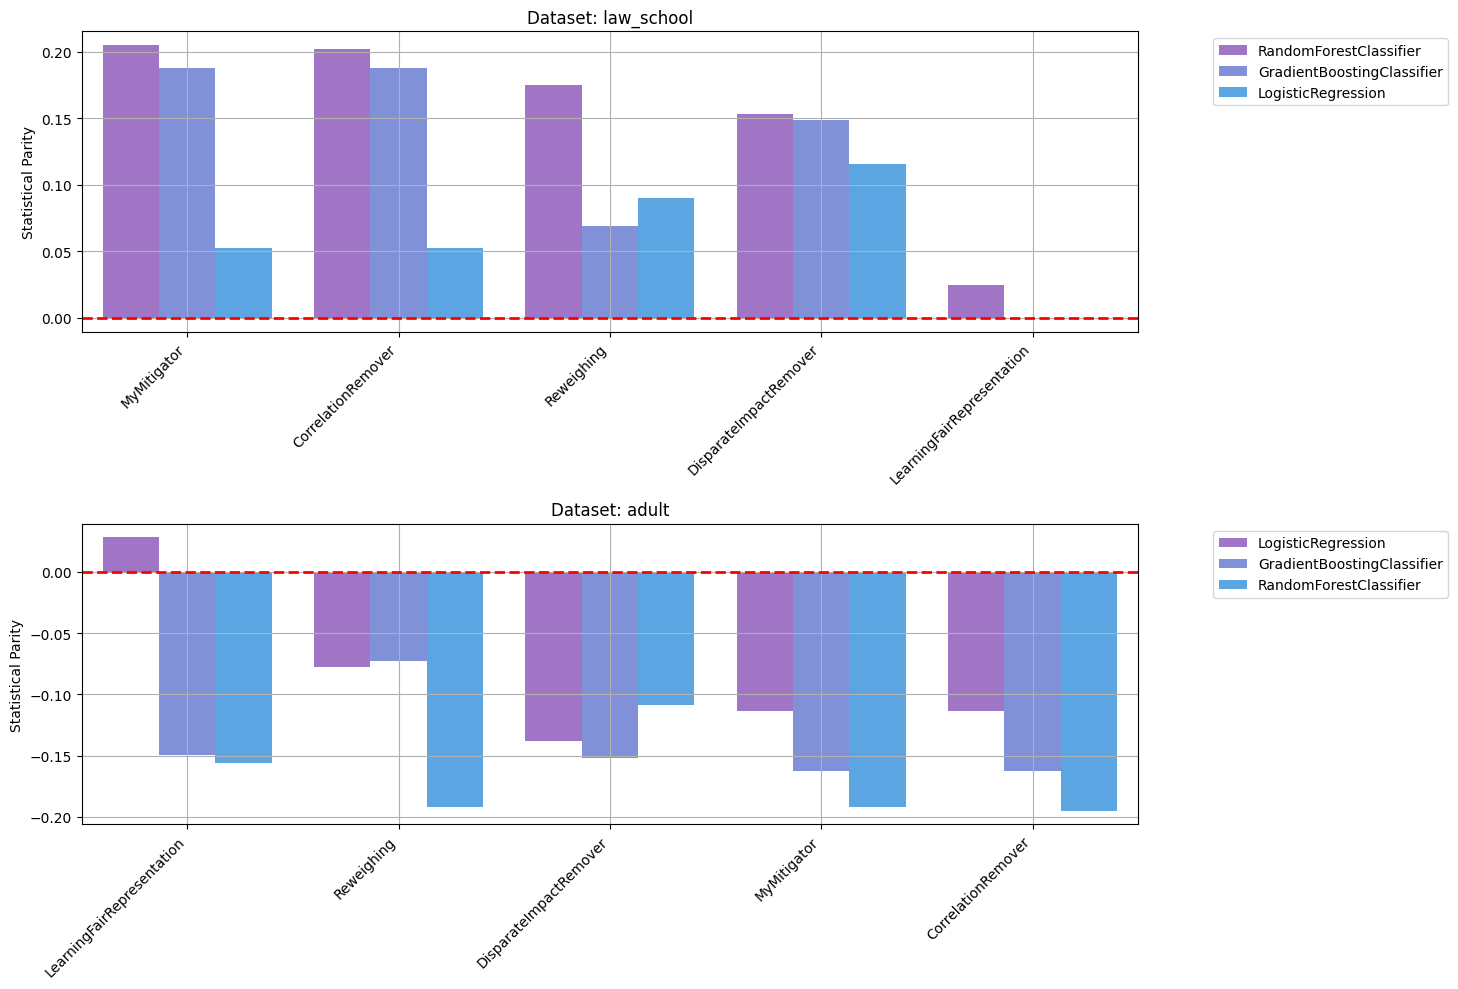

In [ ]:
task.evaluate_plot()

In [5]:
task.submit()

Opening the link in your browser:
